In [32]:
from config_ursse import get_from_config
c = get_from_config("c_m/s")
T = get_from_config("IOTA_revolution_period")
h = get_from_config("RF_q")

In [5]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import fur.path_assistant as path_assistant
import lattice.lattice as lattice
shift_03_16_2020 = path_assistant.PathAssistant('shift_03_16_2020')
lattice_file = shift_03_16_2020.get_6dsim_dir().fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt")
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data
fluctuations_df = get_fluctuations_df_with_acnet_data(
    shift_03_16_2020,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"
)

/home/ilobach/ursse/env/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:173: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)


In [6]:
lattice_df = lattice.read_lattice_file(lattice_file)
lattice_df

,S_cm,Dispersion_cm_X,Beta_cm_X,Beta_cm_Y,Alpha_X,Alpha_Y,dS,dDx,dDx/dS,Phi_X,H
0,0.000000,-24.202678,79.069986,115.457907,3.815143e-07,-1.043665e-07,4.666667,-3.552714e-15,-7.612958e-16,-1.167784e-07,7.408242
1,4.666667,-24.202678,79.345437,115.646529,-5.902559e-02,-4.041888e-02,4.666667,-3.552714e-15,-7.612958e-16,1.800453e-02,7.408245
2,9.333333,-24.202678,80.171797,116.212393,-1.180516e-01,-8.083765e-02,4.666667,0.000000e+00,0.000000e+00,3.563802e-02,7.408254
3,14.000000,-24.202678,81.549066,117.155498,-1.770775e-01,-1.212564e-01,4.666667,-3.552714e-15,-7.612958e-16,5.255426e-02,7.408267
4,18.604167,-24.202678,83.447781,118.455670,-2.353130e-01,-1.611339e-01,4.604167,-3.552714e-15,-7.716301e-16,6.824872e-02,7.408285
...,...,...,...,...,...,...,...,...,...,...,...
911,3976.606466,-24.202678,84.129372,118.922362,2.529686e-01,1.732234e-01,5.000000,-7.105427e-15,-1.421085e-15,-7.277504e-02,7.408291
912,3981.606466,-24.202678,81.915897,117.406657,1.897265e-01,1.299176e-01,5.000000,-1.065814e-14,-2.131628e-15,-5.605616e-02,7.408270
913,3986.606466,-24.202678,80.334842,116.324011,1.264844e-01,8.661173e-02,5.000000,-1.421085e-14,-2.842171e-15,-3.810628e-02,7.408254
914,3991.606466,-24.202678,79.386208,115.674423,6.324232e-02,4.330589e-02,5.000000,-7.105427e-15,-1.421085e-15,-1.928085e-02,7.408245


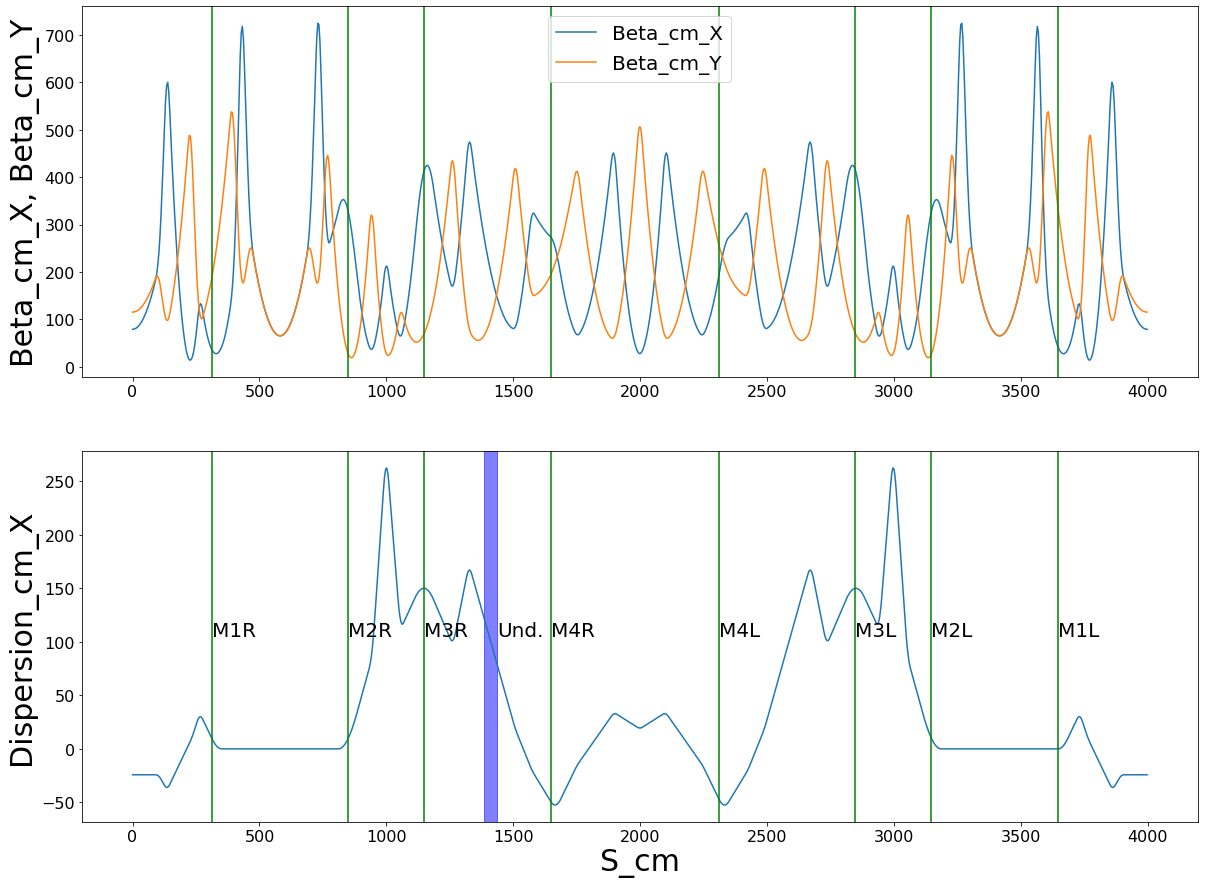

In [7]:
lattice.plot_lattice(lattice_df)

In [9]:
sigma_z_cm, Vrf_V = fluctuations_df.loc[:,["N:IWCMBR", "N:IRFEPA"]].mean().values
dpp = lattice.get_dpp(sigma_z_cm, Vrf_V)
dpp

0.00029019274247975735

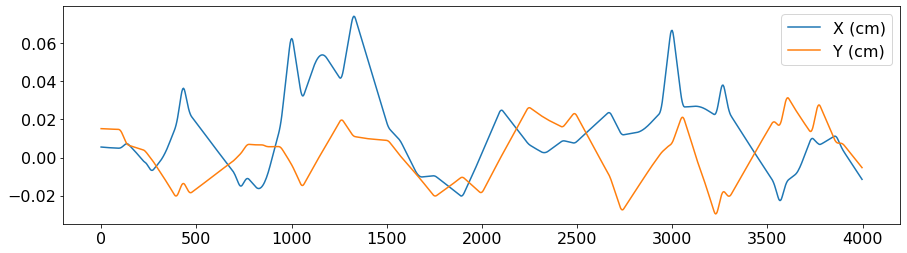

{'phase shift from x (rad)': 8.174714836200699e-07,
 'phase shift from y (rad)': 3.183555357858511e-07}

In [58]:
# https://lss.fnal.gov/archive/test-tm/2000/fermilab-tm-2750-ad.pdf
# https://indico.fnal.gov/event/43231/contributions/187359/attachments/129996/167589/IBSatIOTAcolaborMeeting.pdf
# theoretical zero-current ex = ey = 12 nm
# minimal observed 20 nm
ex = ey = 20e-7 # cm
psi_x0 = 0
psi_y0 = 0
dS = lattice_df['dS']
lattice_df['psi_x'] = np.cumsum(dS/lattice_df['Beta_cm_X'])
x = np.sqrt(ex*lattice_df['Beta_cm_X'])*np.cos(lattice_df['psi_x'])+dpp*lattice_df['Dispersion_cm_X']
lattice_df['psi_y'] = np.cumsum(dS/lattice_df['Beta_cm_Y'])
y = np.sqrt(ex*lattice_df['Beta_cm_Y'])*np.cos(lattice_df['psi_y'])
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(lattice_df['S_cm'], x, label="X (cm)")
ax.plot(lattice_df['S_cm'], y, label="Y (cm)")
ax.legend()
plt.show()

dszx, dszy = np.sum(np.diff(x)**2/2/dS.iloc[:-1]), np.sum(np.diff(y)**2/2/dS.iloc[:-1])
rf_lam = 1e2*T*c/h
{"phase shift from x (rad)": 2*np.pi*dszx/rf_lam, "phase shift from y (rad)": 2*np.pi*dszy/rf_lam}

In [87]:
from scipy.stats import expon, uniform
def get_phase_shifts(ex, ey, psi_x0, psi_y0):
    lattice_df['psi_x'] = np.cumsum(dS/lattice_df['Beta_cm_X'])
    x = np.sqrt(ex*lattice_df['Beta_cm_X'])*np.cos(lattice_df['psi_x'])+dpp*lattice_df['Dispersion_cm_X']
    lattice_df['psi_y'] = np.cumsum(dS/lattice_df['Beta_cm_Y'])
    y = np.sqrt(ey*lattice_df['Beta_cm_Y'])*np.cos(lattice_df['psi_y'])
    dszx, dszy = np.sum(np.diff(x)**2/2/dS.iloc[:-1]), np.sum(np.diff(y)**2/2/dS.iloc[:-1])
    return {"phase_shift_x": 2*np.pi*dszx/rf_lam, "phase_shift_y": 2*np.pi*dszy/rf_lam}

phase_shifts_df = pd.DataFrame([get_phase_shifts(expon.rvs(scale=ex), expon.rvs(scale=ey),
                               2*np.pi*uniform.rvs(), 2*np.pi*uniform.rvs()) for _ in range(2000)])

phase_shifts_df.describe()

,phase_shift_x,phase_shift_y
count,2.000000e+03,2.000000e+03
mean,8.511082e-07,3.130109e-07
std,2.615012e-07,3.249968e-07
min,6.748395e-07,3.154414e-10
25%,6.903716e-07,8.765519e-08
50%,7.474492e-07,2.143978e-07
75%,9.101462e-07,4.413089e-07
max,3.963578e-06,3.118879e-06


In [86]:
phase_shifts_df

,phase_shift_x,phase_shift_y
0,8.762027e-07,1.588395e-07
1,6.896690e-07,3.195712e-08
2,1.063315e-06,1.374349e-07
3,7.401161e-07,2.446045e-07
4,6.751057e-07,2.022762e-07
...,...,...
995,7.813370e-07,8.085247e-07
996,1.071797e-06,4.795115e-07
997,8.547156e-07,4.827671e-08
998,6.992263e-07,1.345346e-07


In [1]:
2.7e-3*100000000


270000.0

In [2]:
59000/12

4916.666666666667